# Deep Learning AI Dev Day - Evaluating an agent

## Getting Set Up

In [ ]:
%pip install dotenv "openai==1.63.0" "arize-phoenix==8.8.0" arize-phoenix-otel openinference-instrumentation-openai "arize-phoenix-client==1.0.1" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.4/231.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203

In [ ]:
import pandas as pd
store_sales_df = pd.read_parquet("https://storage.googleapis.com/arize-phoenix-assets/datasets/unstructured/llm/llama-index/Store_Sales_Price_Elasticity_Promotions_Data.parquet")
store_sales_df.head()

,Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
0,1320,6172800,22875,2021-11-02,3,56.849998,0
1,2310,6172800,22875,2021-11-03,1,18.950001,0
2,3080,6172800,22875,2021-11-03,1,18.950001,0
3,2310,6172800,22875,2021-11-06,1,18.950001,0
4,4840,6172800,22875,2021-11-07,1,18.950001,0


In [ ]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown
import os

# Import tracing libraries
import phoenix as px
from phoenix.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from phoenix.otel import register
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider
from openinference.instrumentation import suppress_tracing
from tqdm import tqdm

In [ ]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from getpass import getpass

os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"
if not os.environ.get("PHOENIX_CLIENT_HEADERS"):
    os.environ["PHOENIX_CLIENT_HEADERS"] = "api_key=" + getpass("Enter your Phoenix API key: ")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f'api_key={os.environ["PHOENIX_CLIENT_HEADERS"]}'


Enter your Phoenix API key: ··········
Enter your OpenAI API key: ··········


In [ ]:
project_name="dl-ai"

### Instrument your app

In [ ]:
import os
from phoenix.otel import register

# configure the Phoenix tracer
tracer_provider = register(
  project_name=project_name,
)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: dl-ai
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [ ]:
MODEL = "gpt-4o-mini"  # You can change this to your preferred model

In [ ]:
OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

# Test OpenAI call
client = OpenAI()
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": "Tell me a short joke."}],
    temperature=0.7,
    max_tokens=50,
)


## Building your agent
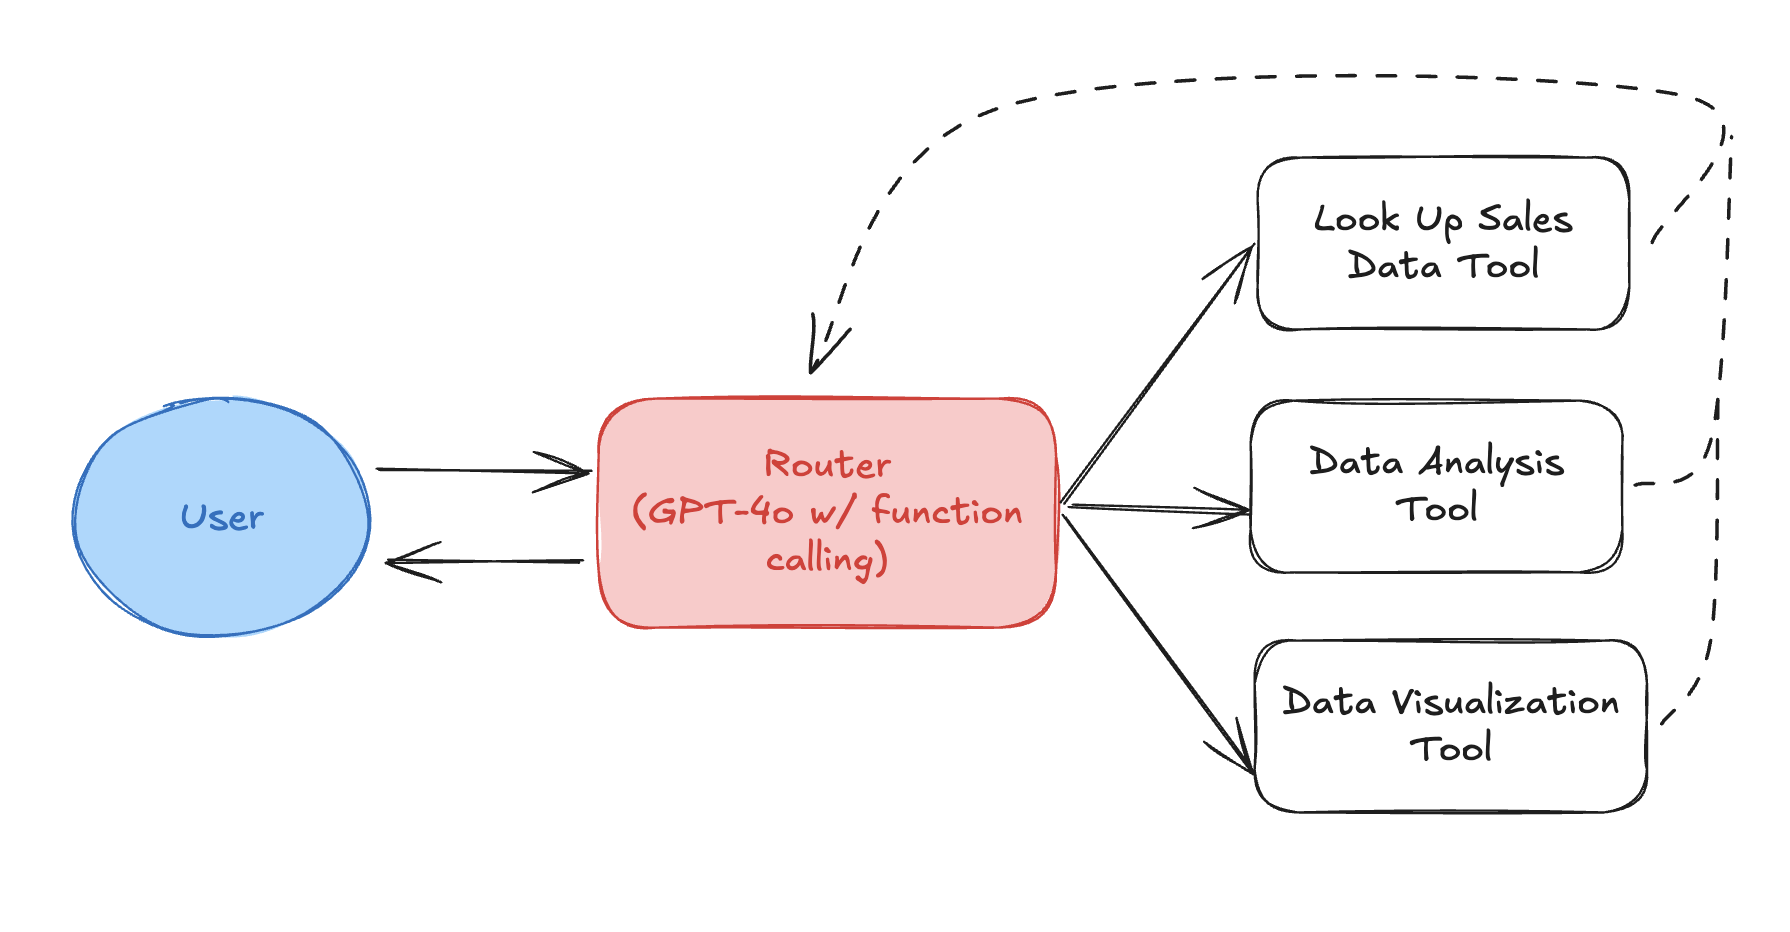

### Tool 1: SQL Generation Tool

In [ ]:
# Get a tracer for our application
tracer = tracer_provider.get_tracer(__name__)

In [ ]:
# ### Tool 1: SQL Generation

SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, columns=columns, table_name=table_name)

    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    return response.choices[0].message.content

@tracer.tool()
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:
        table_name = "sales"
        # Read the parquet file into a DuckDB table
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM store_sales_df")

        sql_query = generate_sql_query(prompt, store_sales_df.columns, table_name)
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")

        with tracer.start_as_current_span("execute_sql_query", openinference_span_kind="chain") as span:
            span.set_input(value=sql_query)

            # Execute the SQL query
            result = duckdb.sql(sql_query).df()
            span.set_output(value=str(result))
            span.set_status(StatusCode.OK)
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

### Tool 2: Data Analysis

In [ ]:

# Prompt template for data analysis
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

@tracer.tool()
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

### Tool 3: Data Visualization


In [ ]:
# Prompt templates for visualization
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

# Class defining the response format for chart configuration
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

@tracer.chain()
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration"""
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data, visualization_goal=visualization_goal)

    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )

    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content

        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        # Fallback configuration
        return {
            "chart_type": "line",
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

@tracer.chain()
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()

    return code

@tracer.tool()
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

## Tool Schema and Router Logic


In [ ]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data",
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data,
    "generate_visualization": generate_visualization
}

In [ ]:
# Code for executing the tools returned in the model's response
@tracer.chain()
def handle_tool_calls(tool_calls, messages):
    for tool_call in tool_calls:
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
    return messages

SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

def run_agent(messages):
    """Run the agent with the given messages"""
    print("Running agent with messages:", messages)

    # Convert string to message format if needed
    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]

    # Add system prompt if not present
    if not any(isinstance(message, dict) and message.get("role") == "system" for message in messages):
        system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
        messages.insert(0, system_prompt)  # Insert at beginning

    while True:
        # Router Span
        print("Starting router call")
        with tracer.start_as_current_span(
            "router_call",
            openinference_span_kind="chain",
        ) as span:
            span.set_input(value=messages)

            response = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                tools=tools,
            )

            # Add response to messages
            messages.append(response.choices[0].message.model_dump())
            tool_calls = response.choices[0].message.tool_calls
            print("Received response with tool calls:", bool(tool_calls))
            span.set_status(StatusCode.OK)

            if tool_calls:
                print("Processing tool calls")
                messages = handle_tool_calls(tool_calls, messages)
                span.set_output(value=tool_calls)
            else:
                print("No tool calls, returning final response")
                span.set_output(value=response.choices[0].message.content)
                return response.choices[0].message.content

def start_main_span(messages):
    """Start the main agent span and run the agent"""
    print("Starting main agent span")

    with tracer.start_as_current_span("AgentRun", openinference_span_kind="agent") as span:
        span.set_input(value=messages)
        result = run_agent(messages)
        print("Main span completed")
        span.set_output(value=result)
        span.set_status(StatusCode.OK)
        return result

## Run the Agent

In [ ]:
# Example query
result = start_main_span("Which stores had the highest sales in November 2021?")
print("\nFinal Result:\n")
print(result)

# Display the result in markdown format
Markdown(result)

# Example visualization query
viz_result = start_main_span("Show me a visualization of sales by store in November 2021")
print("\nVisualization Code:\n")
print(viz_result)

# Execute the visualization code if it looks valid
# Be careful with executing code - only do this if you trust the output
if "import" in viz_result and "plt" in viz_result:
    try:
        # Extract code block if in markdown format
        if "```python" in viz_result:
            code_start = viz_result.find("```python") + 10
            code_end = viz_result.find("```", code_start)
            viz_code = viz_result[code_start:code_end].strip()
        else:
            viz_code = viz_result

        exec(viz_code)
    except Exception as e:
        print(f"Error executing visualization code: {e}")

# ## Check the Phoenix UI
#
# Open the Phoenix UI to see the traces and spans generated by the agent.

Starting main agent span
Running agent with messages: Which stores had the highest sales in November 2021?
Starting router call
Received response with tool calls: True
Processing tool calls
Starting router call
Received response with tool calls: False
No tool calls, returning final response
Main span completed

Final Result:

The stores with the highest sales in November 2021 were:

1. **Store Number 2970**: $31,000.57
2. **Store Number 3300**: $23,730.72
3. **Store Number 1650**: $23,186.91
4. **Store Number 1540**: $21,207.69
5. **Store Number 1210**: $21,021.67
6. **Store Number 1320**: $19,553.79
7. **Store Number 1100**: $19,298.68
8. **Store Number 4840**: $19,127.17
9. **Store Number 3080**: $18,044.45
10. **Store Number 880**: $17,753.77

These figures represent the total sales for each store during that month.
Starting main agent span
Running agent with messages: Show me a visualization of sales by store in November 2021
Starting router call
Received response with tool calls: 

If you want to test with more data

In [ ]:
# from tqdm import tqdm

# agent_questions = [
#     "What was the most popular product SKU?",
#     "What was the total revenue across all stores?",
#     "Which store had the highest sales volume?",
#     "Create a bar chart showing total sales by store",
#     "What percentage of items were sold on promotion?",
#     "Plot daily sales volume over time",
#     "What was the average transaction value?",
#     "Create a box plot of transaction values",
#     "Which products were frequently purchased together?",
#     "Plot a line graph showing the sales trend over time with a 7-day moving average"
# ]

# for question in tqdm(agent_questions, desc="Processing questions"):
#     try:
#         ret = start_main_span([{"role": "user", "content": question}])
#     except Exception as e:
#         print(f"Error processing question: {question}")
#         print(e)
#         continue

# Evaluating the agent

In [ ]:
import phoenix as px
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE,
    llm_classify,
    OpenAIModel
)
from phoenix.trace import SpanEvaluations
from phoenix.experiments import run_experiment, evaluate_experiment
import phoenix as px
from phoenix.trace.dsl import SpanQuery
from phoenix.experiments.types import Example
from phoenix.experiments.evaluators import create_evaluator

import nest_asyncio
nest_asyncio.apply()

In [ ]:
px_client = px.Client()
eval_model = OpenAIModel(model="gpt-4o-mini")

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:40: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(


# Function Calling Evals using LLM as a Judge

In [ ]:
query = SpanQuery().where(
    # Filter for the `RETRIEVER` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    # Extract the span attribute `input.value` which contains the query for the
    # retriever. Rename it as the `input` column in the output dataframe.
    question="input.value",
    output_messages="llm.tools"

)

# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, project_name=project_name, timeout=None)
tool_calls_df = tool_calls_df.dropna(subset=["output_messages"])
tool_calls_df["tool_call"] = tool_calls_df["output_messages"]
tool_calls_df["tool_definitions"] = [tools] * len(tool_calls_df)


tool_calls_df.head()

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


,question,output_messages,tool_call,tool_definitions
context.span_id,,,,
e6e034ff7e9b1513,"{""messages"": [{""role"": ""system"", ""content"": ""\...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'type': 'function', 'function': {'name': 'lo..."
b6dd8a469af46d87,"{""messages"": [{""role"": ""system"", ""content"": ""\...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'type': 'function', 'function': {'name': 'lo..."
bf1612e1ec4d7d0e,"{""messages"": [{""role"": ""system"", ""content"": ""\...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'type': 'function', 'function': {'name': 'lo..."
e5ff45210f42e34e,"{""messages"": [{""role"": ""system"", ""content"": ""\...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'type': 'function', 'function': {'name': 'lo..."
a2b7960c31472db9,"{""messages"": [{""role"": ""system"", ""content"": ""\...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'type': 'function', 'function': {'name': 'lo..."


In [ ]:
with suppress_tracing():
  tool_call_eval = llm_classify(
      dataframe = tool_calls_df,
      template = TOOL_CALLING_PROMPT_TEMPLATE,
      rails = ['correct', 'incorrect'],
      model=eval_model,
      provide_explanation=True
  )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

<ipython-input-21-dcffa0c671b1>:2: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  tool_call_eval = llm_classify(


llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
e6e034ff7e9b1513,correct,The question asks for the stores with the high...,[],COMPLETED,2.718467,1
b6dd8a469af46d87,correct,"The tool call made was to 'lookup_sales_data',...",[],COMPLETED,2.020969,1
bf1612e1ec4d7d0e,correct,The user asked for a visualization of sales by...,[],COMPLETED,2.092725,1
e5ff45210f42e34e,incorrect,"The tool call made was to 'lookup_sales_data',...",[],COMPLETED,1.918065,0
a2b7960c31472db9,correct,The tool calls made in response to the user's ...,[],COMPLETED,2.155569,1


In [ ]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_eval),
)

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:40: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


# Optimizing the Eval Prompt

#### Set up the eval prompt

In [ ]:
print(TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

In [ ]:
from openai import OpenAI
from openai.types.chat.completion_create_params import CompletionCreateParamsBase
from phoenix.client import Client as PhoenixClient

from phoenix.client.types import PromptVersion

messages = [
        {
            "role": "system",
            "content": TOOL_CALLING_PROMPT_TEMPLATE.template[0].template,
        }
    ]

params = CompletionCreateParamsBase(
    model="gpt-4o-mini",
    temperature=0,
    messages=messages
)

prompt_identifier = "function-calling-eval"

eval_prompt = PhoenixClient().prompts.create(
    name=prompt_identifier,
    prompt_description="A prompt for classifying tool call choices",
    version=PromptVersion.from_openai(params, template_format='F_STRING'),
)

### Set up the dataset and experiment

In [ ]:
import uuid
import phoenix as px

unique_id = uuid.uuid4()

agent_tool_responses = {
    "What was the most popular product SKU?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "What was the total revenue across all stores?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Which store had the highest sales volume?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Create a bar chart showing total sales by store": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "What percentage of items were sold on promotion?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Plot daily sales volume over time": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "What was the average transaction value?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Create a box plot of transaction values": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "Which products were frequently purchased together?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Plot a line graph showing the sales trend over time with a 7-day moving average": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "Find the top 10 selling products by quantity": {"tool_calls": "generate_visualization", "label": "incorrect"},
    "Compare sales performance between Monday and Tuesday": {"tool_calls": "generate_visualization", "label": "incorrect"},
    "What is the correlation between promotional items and sales volume?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "incorrect"},
    "Generate a pie chart showing the distribution of sales by product class": {"tool_calls": "ask_for_help", "label": "incorrect"},
    "Translate sales insights report to Spanish": {"tool_calls": "generate_insights", "label": "incorrect"},
    "Identify products with declining sales trends": {"tool_calls": "generate_visualization", "label": "incorrect"},
    "Classify transactions into high-value and low-value segments": {"tool_calls": "lookup_sales_data", "label": "incorrect"},
    "Forecast next quarter's inventory requirements based on sales trends": {"tool_calls": "lookup_sales_data, generate_visualization", "label": "incorrect"},
    "Identify products that have unusually low sales compared to previous months": {"tool_calls": "sql_generation, lookup_sales_data", "label": "correct"},
    "Recommend personalized discounts for top-spending customers": {"tool_calls": "lookup_sales_data, customer_insight_generation", "label": "incorrect"},
    "Generate heatmap visualizing peak sales hours": {"tool_calls": "lookup_sales_data, generate_visualization", "label": "correct"},
    "Evaluate the effectiveness of the recent advertising campaign": {"tool_calls": "generate_visualization", "label": "incorrect"},
    "Segment customers based on product return rates": {"tool_calls": "lookup_sales_data", "label": "correct"},
    "Optimize store staffing levels based on hourly foot traffic": {"tool_calls": "staffing_optimizer, generate_visualization", "label": "incorrect"},
    "Create a forecast of seasonal demand variations using historical patterns": {"tool_calls": "lookup_sales_data, generate_visualization", "label": "incorrect"}
}

}

# Convert the dictionary to a DataFrame
tool_calling_df = pd.DataFrame([(k, v["tool_calls"], v["label"]) for k, v in agent_tool_responses.items()],
                              columns=["question", "tool_calls", "label"])

# Upload the dataset to Phoenix
dataset = px.Client().upload_dataset(
    dataframe=tool_calling_df,
    input_keys=["question", "tool_calls"],
    output_keys=["label"],
    dataset_name=f"function-calling-llm-as-a-judge-{unique_id}",
)

📤 Uploading dataset...
💾 Examples uploaded: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246Mg==


/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:40: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


In [ ]:
def test_prompt(input):
    client = OpenAI()
    resp = client.chat.completions.create(**eval_prompt.format(variables={
        "question": input["question"],
        "tool_call":input["tool_calls"],
        "tool_definitions": tools}))

    return resp.choices[0].message.content.strip()


def evaluate_response(output, expected):
    return output.lower() == expected["label"].lower()

In [ ]:
import nest_asyncio

from phoenix.experiments import run_experiment

nest_asyncio.apply()

initial_experiment = run_experiment(
    dataset,
    task=test_prompt,
    evaluators=[evaluate_response],
    experiment_description="Initial base prompt",
    experiment_name="initial-prompt",
    experiment_metadata={"prompt": "prompt_id=" + eval_prompt.id},
)

🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDox


running tasks |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (03/14/25 11:05 PM +0000)
--------------------------------------------
| evaluator         |   n |   n_scores |   avg_score |   n_labels | top_2_labels             |
|:------------------|----:|-----------:|------------:|-----------:|:-------------------------|
| evaluate_response |  17 |         17 |    0.823529 |         17 | {'True': 14, 'False': 3} |

Tasks Summary (03/14/25 11:05 PM +0000)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           17 |       17 |          0 |


## Optimizing - Few Shot Prompting

In [ ]:
llm_as_a_judge_training = {
    "Find the top 5 selling products by quantity": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Compare sales performance between weekdays and weekends": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Create a heatmap of sales by store and product category": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "What is the correlation between promotional items and sales volume?": {"tool_calls": "lookup_sales_data, analyze_sales_data", "label": "correct"},
    "Generate a pie chart showing the distribution of sales by product class": {"tool_calls": "generate_visualization, lookup_sales_data, run_python_code", "label": "correct"},
    "Generate a pie chart showing the distribution of sales by product class": {"tool_calls": "lookup_sales_data", "label": "incorrect"}
}

# Convert the dictionary to a DataFrame
training_df = pd.DataFrame([(k, v["tool_calls"], v["label"]) for k, v in agent_tool_responses.items()],
                              columns=["question", "tool_calls", "label"])

In [ ]:
new_prompt = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template + """

Here are some examples:
""" + str(training_df.iloc[0]) + "\n\n\n"+ str(training_df.iloc[1])

params = CompletionCreateParamsBase(
    model="gpt-4o-mini",
    temperature=0,
    messages=[
        {
            "role": "system",
            "content": new_prompt,
        },
    ],
)

prompt_identifier = "function-calling-eval"

eval_prompt = PhoenixClient().prompts.create(
    name=prompt_identifier,
    prompt_description="A prompt for classifying tool call choices",
    version=PromptVersion.from_openai(params, template_format='F_STRING'),
)

In [ ]:
def test_prompt(input):
    client = OpenAI()
    resp = client.chat.completions.create(**eval_prompt.format(variables={
        "question": input["question"],
        "tool_call":input["tool_calls"],
        "tool_definitions": tools}))

    return resp.choices[0].message.content.strip()

In [ ]:
import nest_asyncio

from phoenix.experiments import run_experiment

nest_asyncio.apply()

initial_experiment = run_experiment(
    dataset,
    task=test_prompt,
    evaluators=[evaluate_response],
    experiment_description="Few shot prompting",
    experiment_name="few-shot-prompting",
    experiment_metadata={"prompt": "prompt_id=" + eval_prompt.id},
)

🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDoy


/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (03/14/25 11:06 PM +0000)
--------------------------------------------
| evaluator         |   n |   n_scores |   avg_score |   n_labels | top_2_labels             |
|:------------------|----:|-----------:|------------:|-----------:|:-------------------------|
| evaluate_response |  17 |         17 |    0.882353 |         17 | {'True': 15, 'False': 2} |

Tasks Summary (03/14/25 11:05 PM +0000)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           17 |       17 |          0 |


### Optimizing - Meta Prompting

In [ ]:
meta_prompt = """
You are an expert prompt engineer. You are given a prompt, and a list of examples.

Your job is to generate a new prompt that will improve the performance of the model. Only respond with the pure system prompt text content of the new prompt.
Do not format it as an OpenAI prompt.

Here are the examples:

{examples}

Here is the original prompt:

{prompt}

Here is the new prompt string.
"""

original_base_prompt = eval_prompt.format(variables={"question": "{question}", "tool_call": "{tool_call}", "tool_definitions": "{tool_definitions}"})
meta_prompt = meta_prompt.format(prompt=original_base_prompt, examples=llm_as_a_judge_training)

client = OpenAI()
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": meta_prompt,
        }
    ],
)
new_prompt = response.choices[0].message.content.strip()

In [ ]:
new_prompt

'You are an evaluation assistant tasked with assessing whether specific tool calls effectively address the corresponding questions. Your evaluation should consider if the chosen tool is appropriate for the question, whether it uses correct parameters, and if it adheres to the specifications provided. \n\nEach evaluation requires you to analyze the input according to these criteria and provide a concise output.\n\n[BEGIN DATA]\n************\n[Question]: {question}\n************\n[Tool Called]: {tool_call}\n[END DATA]\n\nYour response must be a single word: "correct" if the tool call is suitable and meets all criteria, or "incorrect" if it fails to adequately address the question or does not align with the required formats. \n\n[Tool Definitions]: {tool_definitions}\n\nPlease refer to the following examples for clarity:\nquestion: What was the most popular product SKU?\ntool_calls: lookup_sales_data, analyze_sales_data\nlabel: correct\n\nquestion: What was the total revenue across all st

In [ ]:
params = CompletionCreateParamsBase(
    model="gpt-4o-mini",
    temperature=0,
    messages=[
        {
            "role": "system",
            "content": new_prompt,
        },
    ],
)

prompt_identifier = "function-calling-eval"

eval_prompt = PhoenixClient().prompts.create(
    name=prompt_identifier,
    prompt_description="A prompt for classifying tool call choices",
    version=PromptVersion.from_openai(params, template_format='F_STRING'),
)

In [ ]:
initial_experiment = run_experiment(
    dataset,
    task=test_prompt,
    evaluators=[evaluate_response],
    experiment_description="Meta prompting",
    experiment_name="meta-prompting",
    experiment_metadata={"prompt": "prompt_id=" + eval_prompt.id},
)

🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDoz


/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDoz

Experiment Summary (03/14/25 11:10 PM +0000)
--------------------------------------------
| evaluator         |   n |   n_scores |   avg_score |   n_labels | top_2_labels             |
|:------------------|----:|-----------:|------------:|-----------:|:-------------------------|
| evaluate_response |  17 |         17 |    0.705882 |         17 | {'True': 12, 'False': 5} |

Tasks Summary (03/14/25 11:10 PM +0000)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           17 |       17 |          0 |


### Optimizing - DSPy

In [ ]:
!pip install -q dspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.0/259.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.4/567.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
import dspy
from dspy.teleprompt import BootstrapFewShot
from dspy.evaluate import Evaluate
import pandas as pd

# Configure DSPy to use OpenAI
turbo = dspy.LM(model="gpt-3.5-turbo")
dspy.settings.configure(lm=turbo)


# Define the prompt classification task
class LLMEvalClassifier(dspy.Signature):
    question = dspy.InputField()
    tool_calls = dspy.InputField()
    label = dspy.OutputField(desc="either 'incorrect' or 'correct'")

# Create the basic classifier
classifier = dspy.Predict(LLMEvalClassifier)

In [ ]:
classifier(question="hello", tool_calls="tool 1")

Prediction(
    label='correct'
)

In [ ]:
train_data = []
for _, row in training_df.iterrows():
    question = row['question']
    tool_calls = row['tool_calls']
    label = row['label'] if 'label' in row else None

    example = dspy.Example(
        question=question, tool_calls=tool_calls, label=label
    ).with_inputs("question", "tool_calls")

    train_data.append(example)

In [ ]:
# Define a metric for evaluation
def accuracy_metric(gold, pred):
    return gold['label'] == pred['label']

In [ ]:
tp = dspy.MIPROv2(metric=accuracy_metric, auto="light")
optimized_classifier = tp.compile(classifier, trainset=train_data)

2025/03/14 23:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 5
valset size: 13



Projected Language Model (LM) Calls

Based on the parameters you have set, the maximum number of LM calls is projected as follows:

- Prompt Generation: 10 data summarizer calls + 5 * 1 lm calls in program + (2) lm calls in program-aware proposer = 17 prompt model calls
- Program Evaluation: 13 examples in val set * 7 batches = 91 LM program calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token)
            + (Number of program calls * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may consider:

- Reducing the number

2025/03/14 23:12:40 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/03/14 23:12:40 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/03/14 23:12:40 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=5 sets of demonstrations...


Bootstrapping set 1/5
Bootstrapping set 2/5
Bootstrapping set 3/5


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/5


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/5


 25%|██▌       | 1/4 [00:00<00:01,  2.14it/s]2025/03/14 23:12:44 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'question': 'Create a bar chart showing total sales by store', 'tool_calls': 'generate_visualization, lookup_sales_data, run_python_code', 'label': 'correct'}) (input_keys={'question', 'tool_calls'}) with <function accuracy_metric at 0x7d4ffbd058a0> due to accuracy_metric() takes 2 positional arguments but 3 were given.
2025/03/14 23:12:45 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'question': 'Which store had the highest sales volume?', 'tool_calls': 'lookup_sales_data, analyze_sales_data', 'label': 'correct'}) (input_keys={'question', 'tool_calls'}) with <function accuracy_metric at 0x7d4ffbd058a0> due to accuracy_metric() takes 2 positional arguments but 3 were given.
100%|██████████| 4/4 [00:01<00:00,  2.97it/s]
2025/03/14 23:12:45 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION 

Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.


2025/03/14 23:12:47 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...

2025/03/14 23:13:00 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/03/14 23:13:00 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Classify if a prompt is benign or jailbreak.

2025/03/14 23:13:00 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given the task of classifying if a prompt is benign or jailbreak, you can prompt the Language Model by providing the prompt and specifying the necessary tool calls for text classification. Make sure to include any relevant context or guidelines for the Language Model to accurately determine whether the prompt is benign or related to jailbreak activities.

2025/03/14 23:13:00 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Given a scenario where the prompt could determine whether a security breach is imminent or not, classify if a prompt is benign or indicative of a potential jailbreak.

2025/03/14 23:13:00 INFO dspy.teleprompt.mipro

Average Metric: 5.00 / 13 (38.5%): 100%|██████████| 13/13 [00:01<00:00,  7.42it/s]

2025/03/14 23:13:02 INFO dspy.evaluate.evaluate: Average Metric: 5 / 13 (38.5%)


2025/03/14 23:13:02 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 38.46

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/03/14 23:13:02 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 12.00 / 13 (92.3%): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

2025/03/14 23:13:07 INFO dspy.evaluate.evaluate: Average Metric: 12 / 13 (92.3%)
2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 92.31
2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 92.31 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 1'].
2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31]
2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:07 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====



Average Metric: 11.00 / 13 (84.6%): 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]

2025/03/14 23:13:09 INFO dspy.evaluate.evaluate: Average Metric: 11 / 13 (84.6%)
2025/03/14 23:13:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.62 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/03/14 23:13:09 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31, 84.62]
2025/03/14 23:13:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:09 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====



Average Metric: 12.00 / 13 (92.3%): 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]

2025/03/14 23:13:11 INFO dspy.evaluate.evaluate: Average Metric: 12 / 13 (92.3%)
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 92.31 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 1'].
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31, 84.62, 92.31]
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====



Average Metric: 11.00 / 13 (84.6%): 100%|██████████| 13/13 [00:00<00:00, 775.96it/s]

2025/03/14 23:13:11 INFO dspy.evaluate.evaluate: Average Metric: 11 / 13 (84.6%)
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.62 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31, 84.62, 92.31, 84.62]
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====



Average Metric: 11.00 / 13 (84.6%): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]

2025/03/14 23:13:16 INFO dspy.evaluate.evaluate: Average Metric: 11 / 13 (84.6%)
2025/03/14 23:13:16 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.62 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 3'].
2025/03/14 23:13:16 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31, 84.62, 92.31, 84.62, 84.62]
2025/03/14 23:13:16 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:16 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:16 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====



Average Metric: 12.00 / 13 (92.3%): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

2025/03/14 23:13:18 INFO dspy.evaluate.evaluate: Average Metric: 12 / 13 (92.3%)
2025/03/14 23:13:18 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 92.31 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1'].
2025/03/14 23:13:18 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [38.46, 92.31, 84.62, 92.31, 84.62, 84.62, 92.31]
2025/03/14 23:13:18 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 92.31
2025/03/14 23:13:18 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/14 23:13:18 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 92.31!


In [ ]:
params = CompletionCreateParamsBase(
    model="gpt-4.5",
    temperature=0,
    messages=[
        {
            "role": "system",
            "content": optimized_classifier.signature.instructions,
        },
        {"role": "user", "content": "Question: {{question}} \n Tool Calls: {{tool_calls}}"},
    ],
)

dspy_prompt = PhoenixClient().prompts.create(
    name=prompt_identifier,
    prompt_description="DSPy prompt result",
    version=PromptVersion.from_openai(params),
)

In [ ]:
# Create evaluation function using optimized classifier
def test_dspy_prompt(input):
    result = optimized_classifier(question=input["question"], tool_calls=input["tool_calls"])
    return result.label

In [ ]:
# Run experiment with DSPy-optimized classifier
dspy_experiment = run_experiment(
    dataset,
    task=test_dspy_prompt,
    evaluators=[evaluate_response],
    experiment_description="Prompt Optimization Technique #4: DSPy Prompt Tuning",
    experiment_name="dspy-optimization",
    experiment_metadata={"prompt": "prompt_id=" + dspy_prompt.id},
)

🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDo0


/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.12.1) and client (8.8.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDo0

Experiment Summary (03/14/25 11:13 PM +0000)
--------------------------------------------
| evaluator         |   n |   n_scores |   avg_score |   n_labels | top_2_labels             |
|:------------------|----:|-----------:|------------:|-----------:|:-------------------------|
| evaluate_response |  17 |         17 |    0.705882 |         17 | {'True': 12, 'False': 5} |

Tasks Summary (03/14/25 11:13 PM +0000)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           17 |       17 |          0 |
